In [1]:
!nvidia-smi
%matplotlib inline

Fri Jul 11 15:37:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:32:00.0 Off |                    0 |
| N/A   30C    P0             46W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np

In [3]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [4]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)
learning_A_csv = "../data/learning_version_A.csv"
df_in_context_learning_A = pd.read_csv(learning_A_csv)
learning_B_csv = "../data/learning_version_B.csv"
df_in_context_learning_B = pd.read_csv(learning_B_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

# Wording 1

In [5]:
def dspy_cot_theory_A(lm, input_list, class_to_use):
    category_list = []
    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(request = item)
          category_list.append(result.category)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          category_list.append("error")
          judgment_list.append("error")
          reasoning_list.append("error")

    return category_list, judgment_list, reasoning_list


def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

# Data loading and preprocessing
def load_data_theory_A(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                request=row['request'],
                reasoning=row['reasoning'] if pd.notna(row['reasoning']) else '',
                category=row['category'] if pd.notna(row['category']) else '',
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

def run_experiment_A(test_df, model_in_use, program_in_use, think_file_name, input_col='request'):
  requests_to_test = test_df[input_col].tolist()

  category_list, judgment_list, reasoning_list = dspy_cot_theory_A(model_in_use, requests_to_test, program_in_use)
  df = test_df.copy()
  df['category'] = category_list
  df['model_pred'] = judgment_list
  df['reasoning'] = reasoning_list
  think_list = collect_thinking(model_in_use)
  print(f"The number of thinking pieces is {len(think_list)}.")
  think_df = pd.DataFrame(think_list)
  think_df.to_csv(f'{think_file_name}.csv')

  return df

def retrieve_results(result_df, output_name):
  judgment_list = result_df['model_pred'].tolist()

  if 'error' in judgment_list:
    print("There are errors in model predictions. The CSV file is saved but requires manual inspection.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error is detected, proceed to evaluations.")
    print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

  judgment_gold = result_df['gold_judgment'].tolist()
  judgment_model= result_df['model_pred'].tolist()

  binary_labels = ['underspecified', 'fully specified']

  cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

  disp.plot(cmap='Blues')  # 可以调整 colormap

In [6]:
definitions_and_detailed_instructions = """
For "underspecified" questions/requests, they belong to 4 main categories:


- **Missing necessary components**: There is a strong perception that for at least one expression within the question/request, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole question/request is underspecified.


- **Undetermined lexicons or references**: The question/request contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole question/request is underspecified.


- **Undetermined perspective or granularity**: The question/request contains at least one expression where the general meaning is in place, but its specific interpretation can still vary based on different perspectives or granularities adopted. Multiple interpretations of different levels or natures are plausible for such an expression, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole question/request is underspecified.

- **Undetermined standard or preference**: The question/request contains at least one expression where the general meaning is in place, but its specific interpretation is vague due to unspecified contextual standards or subjective criteria. A wide range of fine-grained interpretations is possible according to contextual or subjective needs, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole question/request is underspecified.

There is only one same-name category of "fully specified" questions/requests, defined as follows:

- **fully specified**: The given question/request is totally clear and definitive, and it doesn't belong to any provided category of "underspecified" questions/requests.
"""

judgment_desc = """
Categories of "underspecified" can only lead to a "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.
"""

## Qwen3-4B DSPy CoT FULL W1

In [7]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', temperature=0.0, max_tokens=5000, cache=False)

dspy.configure(lm=model)

In [8]:
class ClassificationIllustration(dspy.Signature):
  """
  You are an expert analyst. Your task is to analyze and determine whether an input user question/request is "fully specified" or "underspecified".
  When analyzing a given question/request, think step by step in an explicit way:
  First, provide "reasoning" regarding whether it belongs to any of the provided categories of "underspecified" questions/requests or the category of "fully specified" questions/requests.
  Second, assign a "category" to it. It can belong to multiple categories of "underspecified" at the same time, but categories of "underspecified" and the category of "fully specified" are mutual-exclusive.
  Lastly, based on the "category" assigned, determine a "judgment" on whether it is "underspecified" or "fully specified". Categories of "underspecified" can only lead to a "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.


  """
  request: str = dspy.InputField(desc="The input user question/request.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc=definitions_and_detailed_instructions)
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc=judgment_desc)

In [9]:
# Load your in-context learning set
examples = load_data_theory_A(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.ChainOfThought(ClassificationIllustration)
compiled_program = optimizer.compile(program, trainset=examples)

# Saving the program
compiled_program.save("./PROGRAM_Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_A/", save_program=True)

# One-shot Testing
result = compiled_program(request="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    reasoning='The request is underspecified because the term "president" is too general and could refer to multiple parallel political entities (e.g., the President of the United States, the President of France, or the President of China). Without specifying the country or context, the referent remains ambiguous.',
    category='Missing necessary components',
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()

## TEST

In [11]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', temperature=0.0, max_tokens=5000, cache=False)

dspy.configure(lm=model)

In [12]:
experiment_result = run_experiment_A(df_test_1155, model, compiled_program, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_A_think_contents')

Processing: 100%|██████████| 1155/1155 [2:09:38<00:00,  6.73s/it] 

The current length of history is 1283.
The number of thinking pieces is 1283.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.68      0.77      0.72       598
 underspecified       0.71      0.61      0.65       557

       accuracy                           0.69      1155
      macro avg       0.69      0.69      0.69      1155
   weighted avg       0.69      0.69      0.69      1155



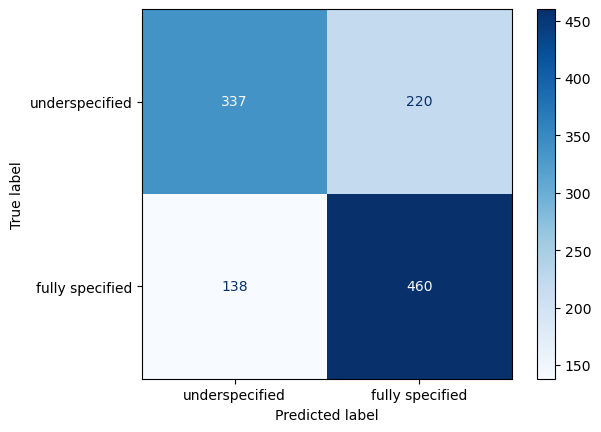

In [13]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_A')

                 precision    recall  f1-score   support

fully specified       0.74      0.73      0.73       431
 underspecified       0.73      0.74      0.73       424

       accuracy                           0.73       855
      macro avg       0.73      0.73      0.73       855
   weighted avg       0.73      0.73      0.73       855



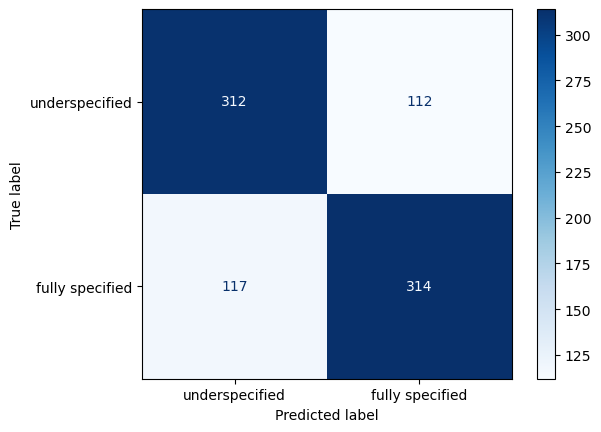

In [16]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_A.csv', 'AmbigQA')

## Qwen3-4B DSPy CoT DEF W1

In [17]:
class ClassificationIllustration(dspy.Signature):
  """
  You are an expert analyst. Your task is to analyze and determine whether an input user question/request is "fully specified" or "underspecified".
  When analyzing a given question/request, think step by step in an explicit way:
  First, provide "reasoning" regarding whether it belongs to any of the provided categories of "underspecified" questions/requests or the category of "fully specified" questions/requests.
  Second, assign a "category" to it. It can belong to multiple categories of "underspecified" at the same time, but categories of "underspecified" and the category of "fully specified" are mutual-exclusive.
  Lastly, based on the "category" assigned, determine a "judgment" on whether it is "underspecified" or "fully specified". Categories of "underspecified" can only lead to a "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.


  """
  request: str = dspy.InputField(desc="The input user question/request.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc=definitions_and_detailed_instructions)
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc=judgment_desc)

In [18]:
# No example, directly compile
program = dspy.ChainOfThought(ClassificationIllustration)

# Saving the program
program.save("./PROGRAM_Qwen3_4B_UND_FS_DSPy_CoT_definitions_no_examples_wording_A/", save_program=True)

# One-shot Testing
result = program(request="Who is the president?")
print(result)

Prediction(
    reasoning='The question "Who is the president?" is ambiguous because the term "president" can refer to different individuals depending on the country or context. Without specifying which country or organization the president belongs to, multiple possible answers exist. This ambiguity arises from the lexical ambiguity of the term "president" when no additional context is provided.',
    category='Undetermined lexicons or references',
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()

### TEST

In [20]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', temperature=0.0, max_tokens=5000, cache=False)

dspy.configure(lm=model)

In [21]:
experiment_result = run_experiment_A(df_test_1155, model, program, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_no_examples_wording_A_think_contents')

Processing: 100%|██████████| 1155/1155 [1:41:26<00:00,  5.27s/it] 

The current length of history is 1156.
The number of thinking pieces is 1156.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.64      0.77      0.70       598
 underspecified       0.68      0.54      0.60       557

       accuracy                           0.66      1155
      macro avg       0.66      0.65      0.65      1155
   weighted avg       0.66      0.66      0.65      1155



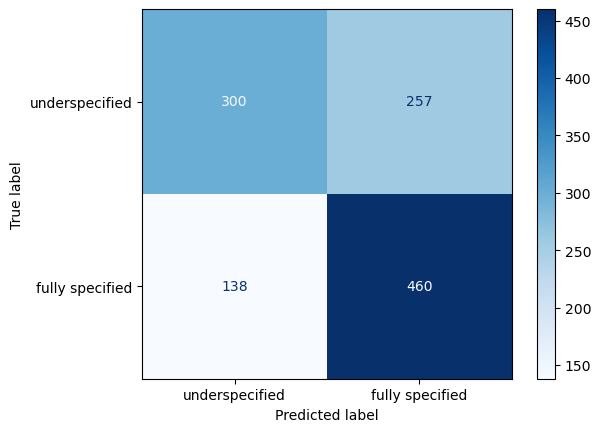

In [22]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_no_examples_wording_A')

                 precision    recall  f1-score   support

fully specified       0.68      0.76      0.71       431
 underspecified       0.72      0.63      0.67       424

       accuracy                           0.70       855
      macro avg       0.70      0.70      0.69       855
   weighted avg       0.70      0.70      0.69       855



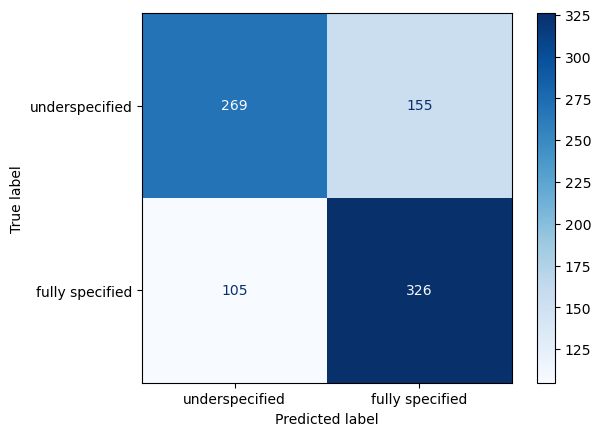

In [23]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_CoT_definitions_no_examples_wording_A.csv', 'AmbigQA')

# Wording 2

In [7]:
def dspy_cot_theory_B(lm, input_list, class_to_use):
    category_list = []
    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(query = item)
          category_list.append(result.category)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          category_list.append("error")
          judgment_list.append("error")
          reasoning_list.append("error")

    return category_list, judgment_list, reasoning_list


def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

# Data loading and preprocessing
def load_data_theory_B(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                query=row['request'],
                reasoning=row['reasoning'] if pd.notna(row['reasoning']) else '',
                category=row['category'] if pd.notna(row['category']) else '',
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

def run_experiment_B(test_df, model_in_use, program_in_use, think_file_name, input_col='request'):
  requests_to_test = test_df[input_col].tolist()

  category_list, judgment_list, reasoning_list = dspy_cot_theory_B(model_in_use, requests_to_test, program_in_use)
  df = test_df.copy()
  df['category'] = category_list
  df['model_pred'] = judgment_list
  df['reasoning'] = reasoning_list
  think_list = collect_thinking(model_in_use)
  print(f"The number of thinking pieces is {len(think_list)}.")
  think_df = pd.DataFrame(think_list)
  think_df.to_csv(f'{think_file_name}.csv')

  return df

def retrieve_results(result_df, output_name):
  judgment_list = result_df['model_pred'].tolist()

  if 'error' in judgment_list:
    print("There are errors in model predictions. The CSV file is saved but requires manual inspection.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error is detected, proceed to evaluations.")
    print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

  judgment_gold = result_df['gold_judgment'].tolist()
  judgment_model= result_df['model_pred'].tolist()

  binary_labels = ['underspecified', 'fully specified']

  cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

  disp.plot(cmap='Blues')  # 可以调整 colormap

In [8]:
definitions_and_detailed_instructions = """
For "underspecified" queries, they belong to 4 main categories:


- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.


- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.


- **Undetermined perspective or granularity**: The query contains at least one expression where the general meaning is in place, but its specific interpretation can still vary based on different perspectives or granularities adopted. Multiple interpretations of different levels or natures are plausible for such an expression, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

- **Undetermined standard or preference**: The query contains at least one expression where the general meaning is in place, but its specific interpretation is vague due to unspecified contextual standards or subjective criteria. A wide range of fine-grained interpretations is possible according to contextual or subjective needs, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

There is only one same-name category of "fully specified" queries, defined as follows:

- **fully specified**: The given query is totally clear and definitive, and it doesn't belong to any provided category of "underspecified" queries.
"""

judgment_desc = """
Categories of "underspecified" can only lead to a "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.
"""

## Qwen3-4B DSPy CoT FULL W2

In [11]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', temperature=0.0, max_tokens=5000, cache=False)

dspy.configure(lm=model)

In [12]:
class ClassificationIllustration(dspy.Signature):
  """
  You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".
  When analyzing a given query, think step by step in an explicit way:
  First, provide "reasoning" regarding whether it belongs to any of the provided categories of "underspecified" queries or the category of "fully specified" queries.
  Second, assign a "category" to it. It can belong to multiple categories of "underspecified" at the same time, but categories of "underspecified" and the category of "fully specified" are mutual-exclusive.
  Lastly, based on the "category" assigned, determine a "judgment" on whether it is "underspecified" or "fully specified". Categories of "underspecified" can only lead to an "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.


  """
  query: str = dspy.InputField(desc="The input user query.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc=definitions_and_detailed_instructions)
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc=judgment_desc)

In [13]:
# Load your in-context learning set
examples = load_data_theory_B(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.ChainOfThought(ClassificationIllustration)
compiled_program = optimizer.compile(program, trainset=examples)

# Saving the program
compiled_program.save("./PROGRAM_Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_B/", save_program=True)

# One-shot Testing
result = compiled_program(query="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    reasoning='The request is underspecified because the term "president" is ambiguous without specifying which country or political entity is being referred to. The referent could be the President of the United States, the President of France, the President of China, or another nation, each with distinct individuals. Without clarifying the context, the question lacks a specific referent.',
    category='Undetermined lexicons or references',
    judgment='underspecified'
)


In [14]:
dspy.inspect_history()





[2025-07-11T15:42:11.682401]

System message:

Your input fields are:
1. `query` (str): The input user query.

Your output fields are:
1. `reasoning` (str)
2. `category` (Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']): 
For "underspecified" queries, they belong to 4 main categories:


- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.


- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lex

### TEST

In [15]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', temperature=0.0, max_tokens=5000, cache=False)

dspy.configure(lm=model)

In [16]:
experiment_result = run_experiment_B(df_test_1155, model, compiled_program, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_B_think_contents')

Processing: 100%|██████████| 1155/1155 [2:08:15<00:00,  6.66s/it] 

The current length of history is 1310.
The number of thinking pieces is 1310.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.68      0.75      0.71       598
 underspecified       0.70      0.61      0.65       557

       accuracy                           0.68      1155
      macro avg       0.69      0.68      0.68      1155
   weighted avg       0.69      0.68      0.68      1155



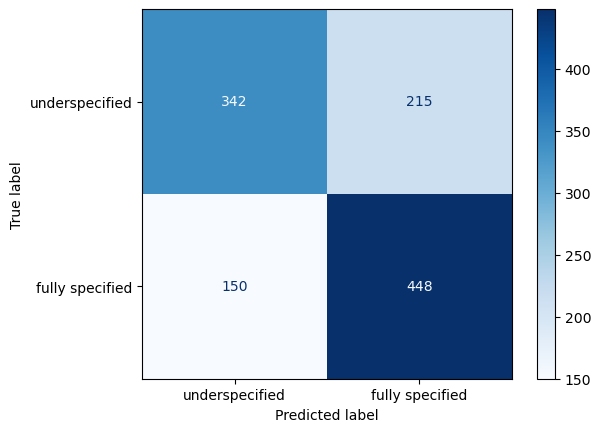

In [17]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_B')

                 precision    recall  f1-score   support

fully specified       0.74      0.72      0.73       431
 underspecified       0.72      0.75      0.73       424

       accuracy                           0.73       855
      macro avg       0.73      0.73      0.73       855
   weighted avg       0.73      0.73      0.73       855



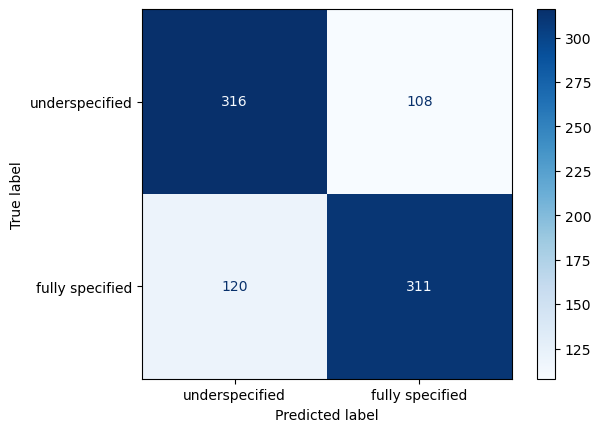

In [18]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_B.csv', 'AmbigQA')

## Qwen3-4B DSPy CoT DEF W2

In [19]:
class ClassificationIllustration(dspy.Signature):
  """
  You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".
  When analyzing a given query, think step by step in an explicit way:
  First, provide "reasoning" regarding whether it belongs to any of the provided categories of "underspecified" queries or the category of "fully specified" queries.
  Second, assign a "category" to it. It can belong to multiple categories of "underspecified" at the same time, but categories of "underspecified" and the category of "fully specified" are mutual-exclusive.
  Lastly, based on the "category" assigned, determine a "judgment" on whether it is "underspecified" or "fully specified". Categories of "underspecified" can only lead to an "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.


  """
  query: str = dspy.InputField(desc="The input user query.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc=definitions_and_detailed_instructions)
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc=judgment_desc)

In [20]:
# No example, directly compile
program = dspy.ChainOfThought(ClassificationIllustration)

# Saving the program
program.save("./PROGRAM_Qwen3_4B_UND_FS_DSPy_CoT_definitions_no_examples_wording_B/", save_program=True)

# One-shot Testing
result = program(query="Who is the president?")
print(result)

Prediction(
    reasoning='The query "Who is the president?" is ambiguous because the term "president" can refer to different individuals depending on the country. Without specifying which country\'s president is being asked, the query lacks clarity. This ambiguity arises from the lexical reference to "president" without contextual information to determine the intended entity.',
    category='Undetermined lexicons or references',
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()

### TEST

In [22]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', temperature=0.0, max_tokens=5000, cache=False)

dspy.configure(lm=model)

In [23]:
experiment_result = run_experiment_B(df_test_1155, model, program, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_examples_wording_B_think_contents')

Processing: 100%|██████████| 1155/1155 [1:39:44<00:00,  5.18s/it]

The current length of history is 1156.
The number of thinking pieces is 1156.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.62      0.78      0.69       598
 underspecified       0.67      0.49      0.57       557

       accuracy                           0.64      1155
      macro avg       0.65      0.64      0.63      1155
   weighted avg       0.65      0.64      0.63      1155



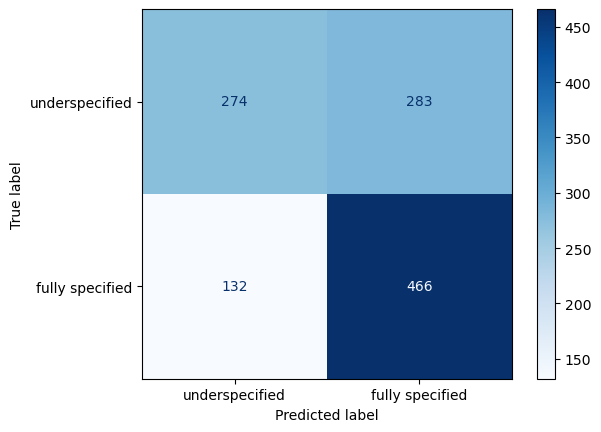

In [24]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_CoT_definitions_no_examples_wording_B')

                 precision    recall  f1-score   support

fully specified       0.65      0.77      0.71       431
 underspecified       0.71      0.58      0.64       424

       accuracy                           0.68       855
      macro avg       0.68      0.68      0.67       855
   weighted avg       0.68      0.68      0.67       855



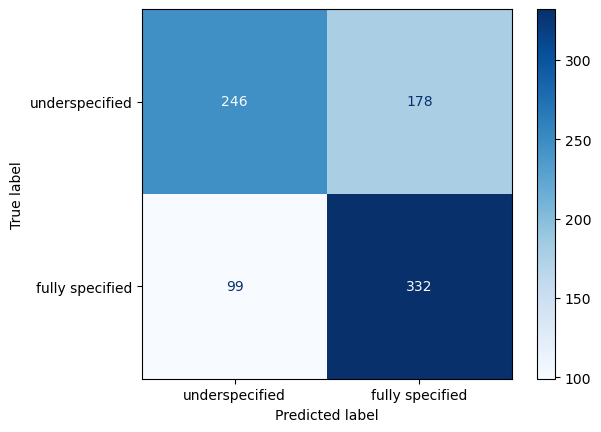

In [25]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_CoT_definitions_no_examples_wording_B.csv', 'AmbigQA')

## Supplementary: Qwen3-4B DSPy CoT MINI W1

In [ ]:
def dspy_cot_theory(lm, input_list, class_to_use):
    category_list = []
    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(request = item)
          category_list.append(result.category)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          category_list.append("error")
          judgment_list.append("error")
          reasoning_list.append("error")

    return category_list, judgment_list, reasoning_list


def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

# Data loading and preprocessing
def load_data_theory(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                request=row['request'],
                reasoning=row['reasoning'] if pd.notna(row['reasoning']) else '',
                category=row['category'] if pd.notna(row['category']) else '',
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

def run_experiment(test_df, model_in_use, program_in_use, think_file_name, input_col='request', theory=False):
  requests_to_test = test_df[input_col].tolist()

  if theory:
    category_list, judgment_list, reasoning_list = dspy_cot_theory(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['category'] = category_list
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  else:
    judgment_list, reasoning_list = dspy_cot_no_theory(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  return df

def retrieve_results(result_df, output_name):
  judgment_list = result_df['model_pred'].tolist()

  if 'error' in judgment_list:
    print("There are errors in model predictions. The CSV file is saved but requires manual inspection.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error is detected, proceed to evaluations.")
    print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

  judgment_gold = result_df['gold_judgment'].tolist()
  judgment_model= result_df['model_pred'].tolist()

  binary_labels = ['underspecified', 'fully specified']

  cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

  disp.plot(cmap='Blues')  # 可以调整 colormap

In [27]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)

In [28]:
class Classification(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc="Select one or more labels (comma-separated): Undetermined perspective or granularity, Missing necessary components, Undetermined lexicons or references, Undetermined standard or preference. If fully clear, output 'fully specified'")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc="Final judgment: 'underspecified' if any undetermined factors exist, 'fully specified' if completely clear.")

In [29]:
# No example, directly compile
program = dspy.ChainOfThought(Classification)

# Saving the program
program.save("./PROGRAM_Qwen3_4B_UND_FS_DSPy_CoT_instructions_no_examples_wording_A", save_program=True)

# One-shot Testing
result = program(request="Who is the president?")
print(result)

Prediction(
    reasoning='The question "Who is the president?" lacks specification of the country or context in which the president is being asked about. Without additional information, it is ambiguous which president the user is referring to.',
    category='Missing necessary components',
    judgment='underspecified'
)


In [30]:
dspy.inspect_history()





[2025-07-11T19:37:31.214333]

System message:

Your input fields are:
1. `request` (str): An input user question/request.

Your output fields are:
1. `reasoning` (str)
2. `category` (Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']): Select one or more labels (comma-separated): Undetermined perspective or granularity, Missing necessary components, Undetermined lexicons or references, Undetermined standard or preference. If fully clear, output 'fully specified'
3. `judgment` (Literal['underspecified', 'fully specified']): Final judgment: 'underspecified' if any undetermined factors exist, 'fully specified' if completely clear.

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## request ## ]]
{request}

[[ ## reasoning ## ]]
{reasoning}

[[ ## category ## ]]
{category}        # note: the value you produ

In [33]:
experiment_result = run_experiment(df_test_1155, model, program, 'Qwen3_4B_UND_FS_DSPy_CoT_instructions_no_examples_wording_A_think_contents', theory=True)

Processing: 100%|██████████| 1155/1155 [1:45:29<00:00,  5.48s/it] 

The current length of history is 1409.
The number of thinking pieces is 1409.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.64      0.70      0.67       598
 underspecified       0.64      0.58      0.61       557

       accuracy                           0.64      1155
      macro avg       0.64      0.64      0.64      1155
   weighted avg       0.64      0.64      0.64      1155



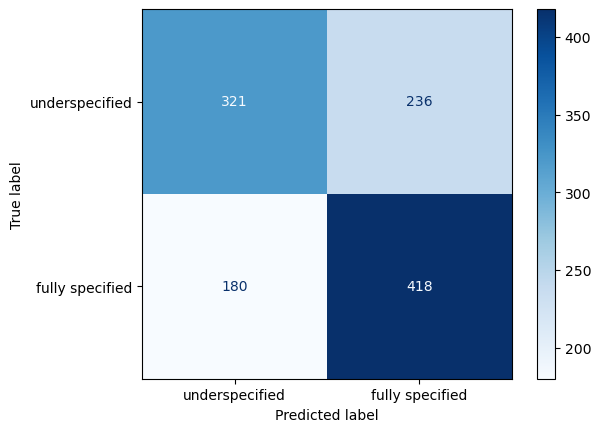

In [34]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_CoT_instructions_no_examples_wording_A')

                 precision    recall  f1-score   support

fully specified       0.68      0.67      0.67       431
 underspecified       0.67      0.68      0.67       424

       accuracy                           0.67       855
      macro avg       0.67      0.67      0.67       855
   weighted avg       0.67      0.67      0.67       855



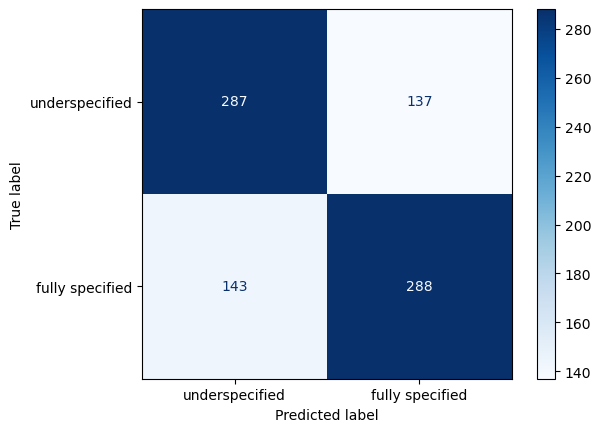

In [35]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_CoT_instructions_no_examples_wording_A.csv', 'AmbigQA')